In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score

from scipy.special import logsumexp

from mlgrad.funcs import Exp, Hinge, Hinge2
from sys import float_info

In [2]:
class MarginMaximizationExp:

    def __init__(self, alpha, tol=1.0e-9, n_iter=1000):
        self.tol = tol
        self.n_iter = n_iter
        self.alpha = alpha
        self.c = None
        self.w = None
    #
    def fit(self, X, Y):
        tol = self.tol
        exp = np.exp
        log = np.log
        alpha = self.alpha

        I1 = (Y == -1)
        I2 = (Y == +1)

        N, n = X.shape

        if self.w is None:
            w = 2*np.random.random(n)-1
            w /= np.sqrt(w @ w)
            w_max = w
        else:
            w_max = w = self.w
        
        if self.c is None:
            c = c_max = 0
        else:
            c = c_max = self.c

        Xw = X @ w
        U = (Xw - c) * Y

        # U_min = U.min()
        # U_max = U.max()

        lval = lval_max = -logsumexp(-alpha * U) / alpha
        lvals = [lval]

        finish = False
        for K in range(self.n_iter):

            DU = exp(-alpha*U).sum()
            DUY = DU * Y

            w_1 = (X.T @ DUY) / (DUY @ Xw)
            wn = np.sqrt(w_1 @ w_1)
            w = w_1 / wn

            # Xw1 = Xw[I1]
            # Xw2 = Xw[I2]
            # V1 = exp(alpha * Xw1).sum()
            # V2 = exp(-alpha * Xw2).sum()
            c =  (logsumexp(alpha*Xw[I1]) - logsumexp(-alpha*Xw[I2])) / (2*alpha)
            
            Xw = X @ w
            U = (Xw - c)*Y
    
            # U_min = U.min()
            # U_max = U.max()
            
            lval = -logsumexp(-alpha * U) /alpha
            lvals.append(lval)

            if abs(lval - lval_max) < tol:
                finish = True
            
            if lval > lval_max:
                lval_max = lval
                w_max = w
                c_max = c

            if finish:
                break

        self.K = K + 1
        self.w = w_max
        self.c = c_max
        self.lvals = lvals

    def evaluate(self, X):
        return X @ self.w - self.c

In [3]:
X, Y = datasets.load_iris(return_X_y=True)
U = decomposition.PCA(n_components=2).fit_transform(X)

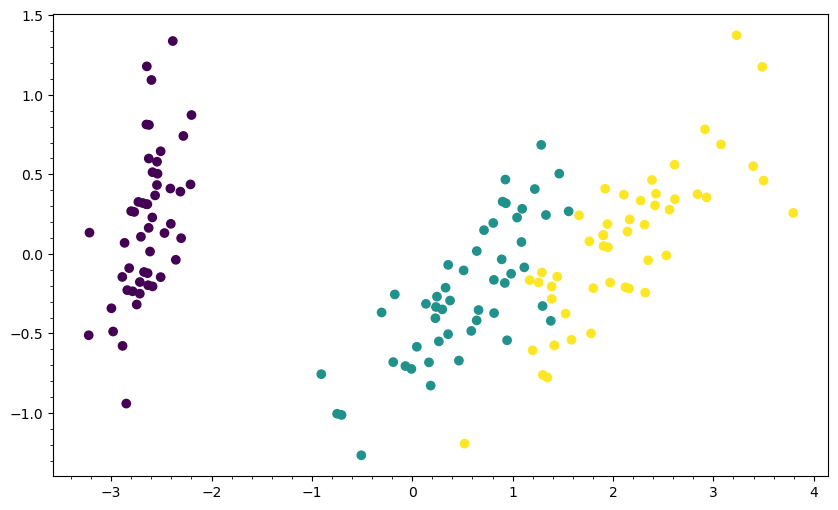

In [4]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U[:,0], U[:,1], c=Y, s=36)
plt.minorticks_on()
plt.show()

In [5]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]
np.putmask(Y2, Y2 == 1, -1)
np.putmask(Y2, Y2 == 2, +1)
Y2 = Y2.astype('d')
N = len(Y2)

In [6]:
def calc_zz(mod, xr, yr):
    xrange = np.linspace(xr[0], xr[1], 101)
    yrange = np.linspace(yr[0], yr[1], 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

In [7]:
mm = MarginMaximizationExp(7.)

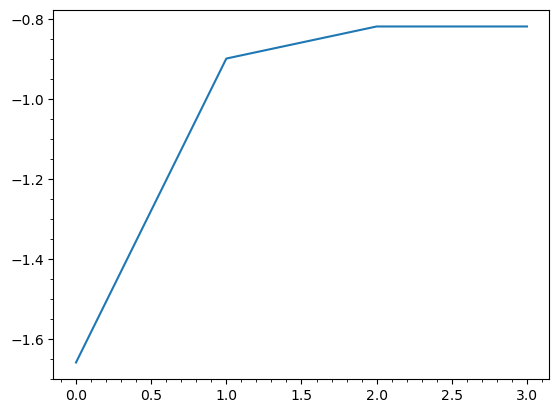

[0.982 0.187]
3


In [8]:
mm.fit(U2, Y2)
plt.plot(mm.lvals)
plt.minorticks_on()
plt.show()
print(mm.w)
print(mm.K)

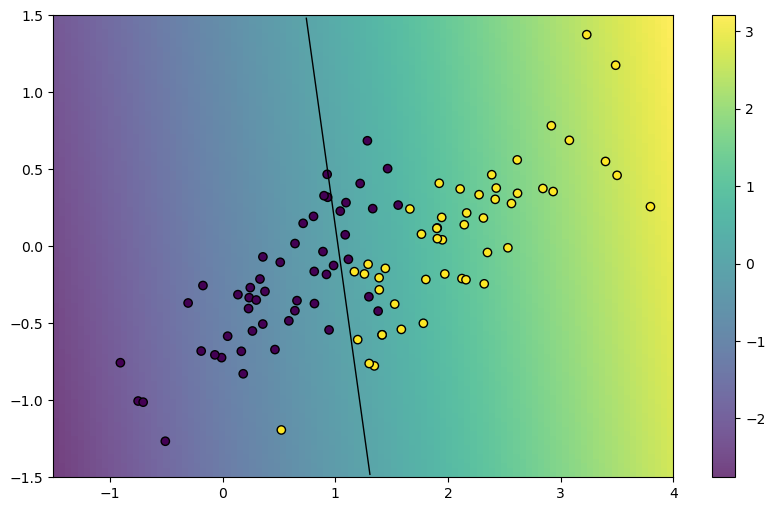

In [9]:
ZZ = calc_zz(mm, [-1.5, 4], [-1.5, 1.5])
extent = (-1.5, 4, -1.5, 1.5)
plt.figure(figsize=(10,6))
plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=36)
cb = plt.imshow(ZZ, origin='lower', extent=extent, alpha=0.75, aspect='auto')
plt.colorbar(cb)
plt.contour(ZZ, levels=[0], origin='lower', extent=extent, linewidths=1, colors='k')
plt.show()

In [10]:
accuracy_score(Y2, np.sign(mm.evaluate(U2)))

0.88